In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!wandb login 9676e3cc95066e4865586082971f2653245f09b4

In [117]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats, optimize
from scipy.special import factorial

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import path as mpath

import pickle
import tabulate
import wandb
from collections import namedtuple

import meta_learning_data_analysis as analysis
import meta_learning_analysis_plots as plots

In [ ]:
np.set_printoptions(linewidth=100)

MIN_FONT_SIZE = 14
LABELS_FONT_SIZE = 20
TITLE_FONT_SIZE = 24

matplotlib.rcParams.update({'font.size': MIN_FONT_SIZE})
FONT_DICT = dict(fontsize=LABELS_FONT_SIZE) 
TITLE_FONT_DICT = dict(fontsize=TITLE_FONT_SIZE)

PER_PLOT_WIDTH = 6

In [ ]:
api = wandb.Api()

In [76]:
cache = analysis.refresh_cache()
print(cache.keys())

dict_keys(['six_replications_analyses', 'control_analyses', 'query_mod_replications', 'six_replications_updated_analyses', 'updated_control_analyses', 'query_mod_updated_analyses'])


In [77]:
forgetting_exp_path = 'meta-learning-scaling/sequential-benchmark-forgetting-experiment-revisited'
forgetting_exp_pattern = 'meta-learning-scaling/sequential-benchmark-forgetting-experiment-revisited/{run_id}'

In [78]:
if 'forgetting_curves_raw_data' in cache:
    forgetting_curves_raw_data = cache['forgetting_curves_raw_data']

else:
    forgetting_runs = api.runs(forgetting_exp_path)
    print('Loaded runs')
    
    trajectories = [analysis.parse_forgetting_results(current_run=run) for run in forgetting_runs]
    forgetting_curves_raw_data = np.stack(trajectories)
    cache = analysis.refresh_cache(dict(forgetting_curves_raw_data=forgetting_curves_raw_data))


Loaded runs
Starting to parse run u7t6n1hd
Starting to parse run r6gc4st4
Starting to parse run s5pdw5x4
Starting to parse run usyuqn8w
Starting to parse run dbqboflu
Starting to parse run n15vqjrf
Starting to parse run 8griea8l
Starting to parse run 1d8r45mq
Starting to parse run zh1toer7
Starting to parse run 6eowkah6
Starting to parse run xk5pifxt
Starting to parse run 8wgfg3kf
Starting to parse run llgr3gxh
Starting to parse run 3ryjb722
Starting to parse run bb6yu1md
Starting to parse run bsfuuyiv
Starting to parse run vzov4kox
Starting to parse run rm0xdcdc
Starting to parse run eefw97mf
Starting to parse run a0pidnb6
Starting to parse run 5i91mhb5
Starting to parse run qlbfrpte
Starting to parse run 50svhz73
Starting to parse run 6ge4um9p
Starting to parse run htjgeqls
Starting to parse run rz1cwwo0
Starting to parse run puam76u9
Starting to parse run b71i7ju1
Starting to parse run l14mw202
Starting to parse run 1p4n1uc7
Starting to parse run lwexfc7v
Starting to parse run pxar2

## Initial data visualization

Solid black line is the mean, cyan area is two SEMs around the mean

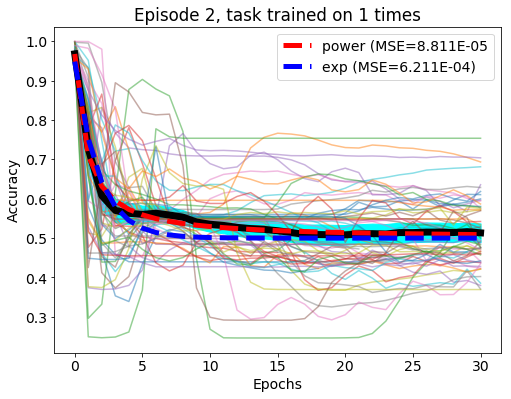

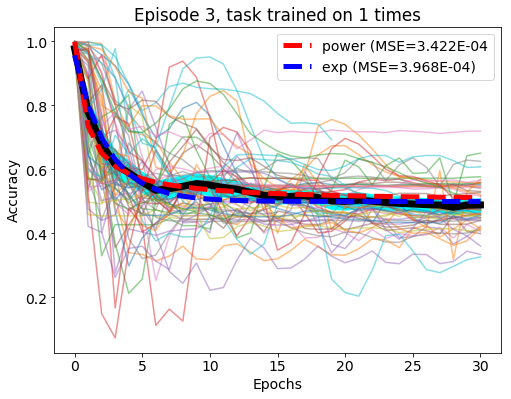

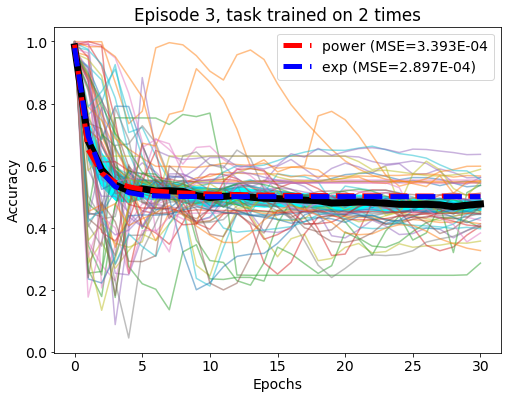

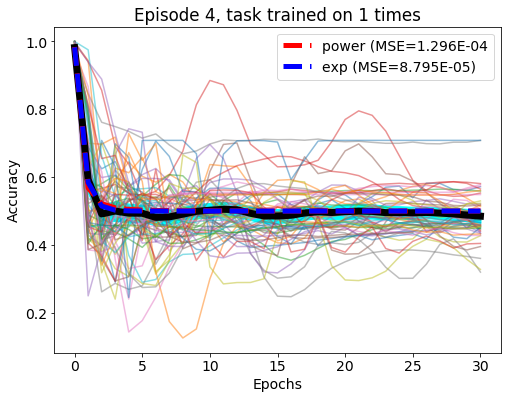

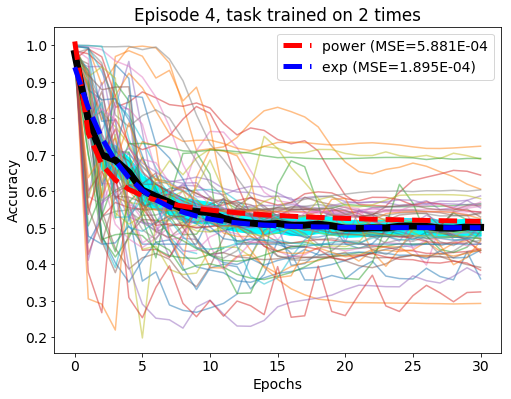

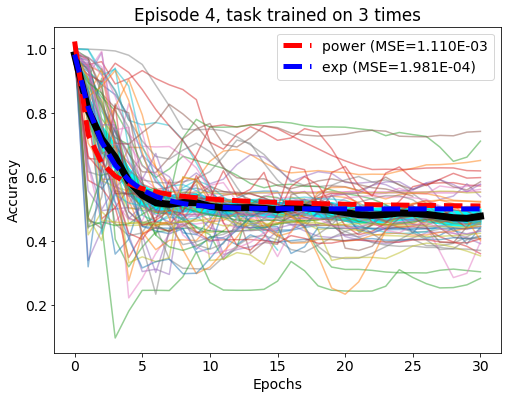

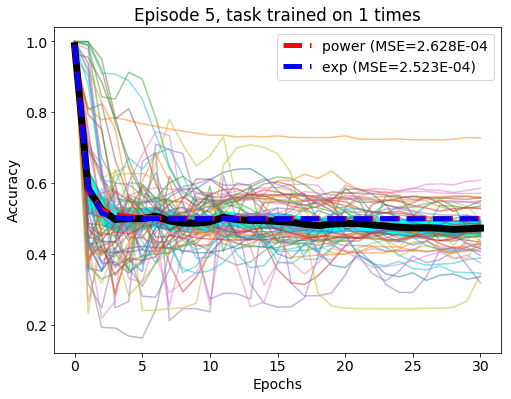

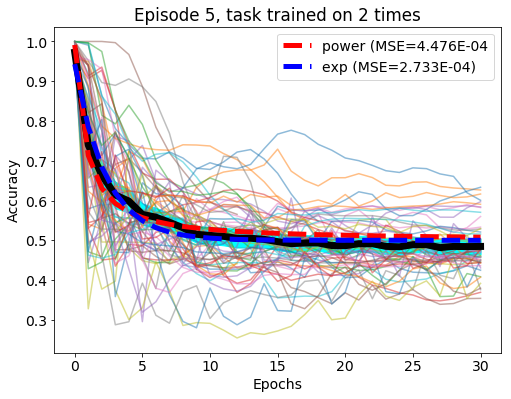

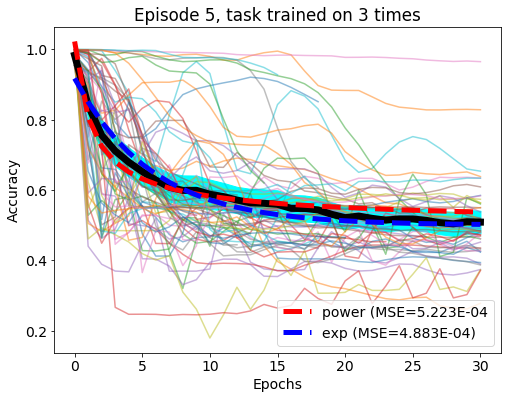

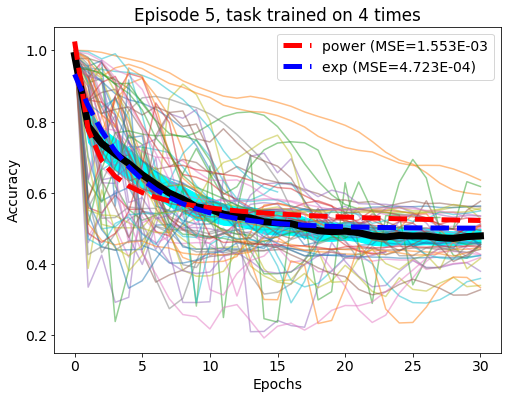

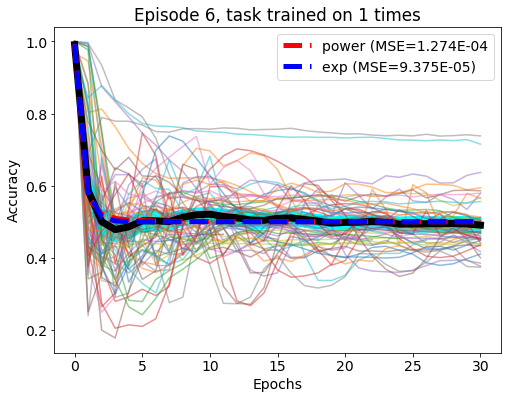

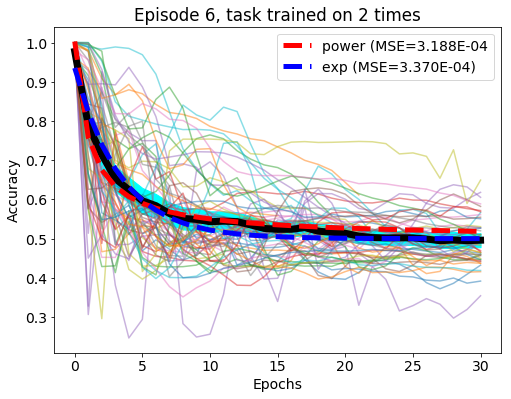

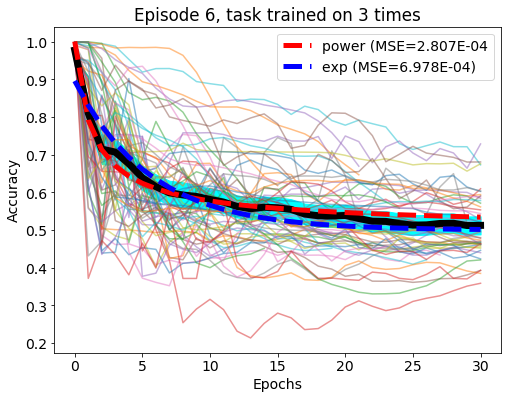

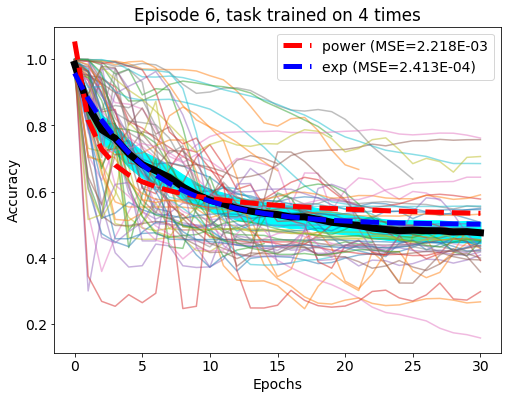

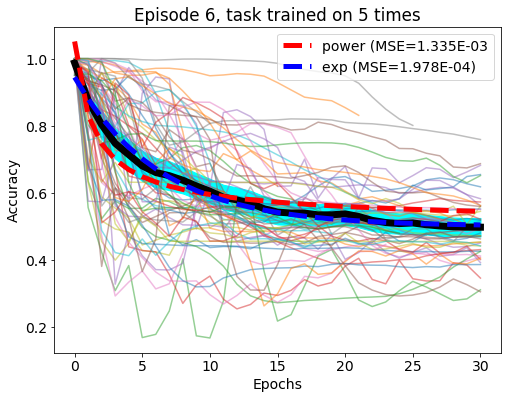

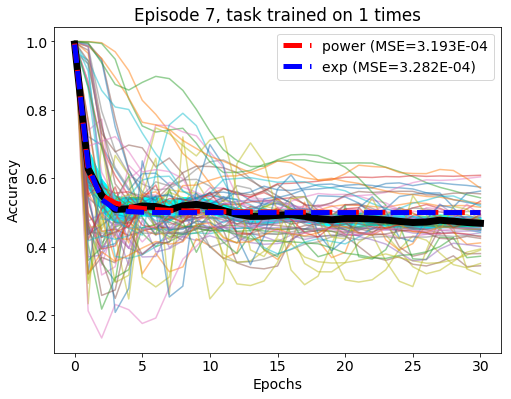

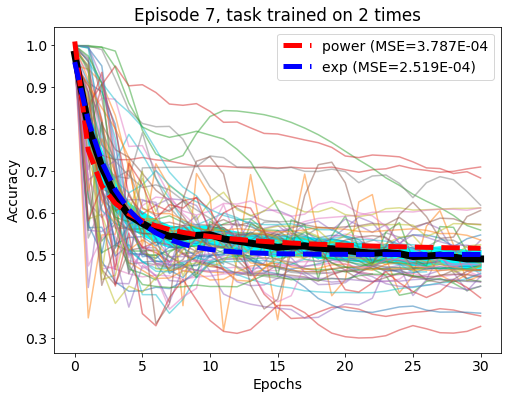

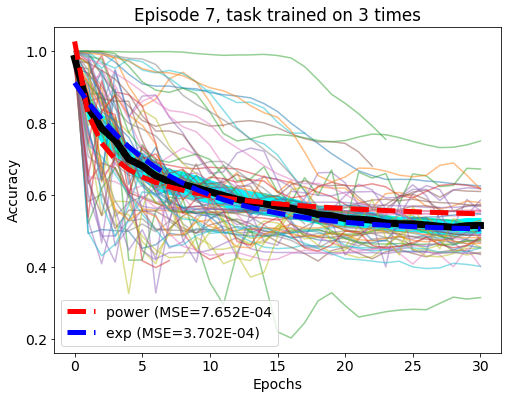

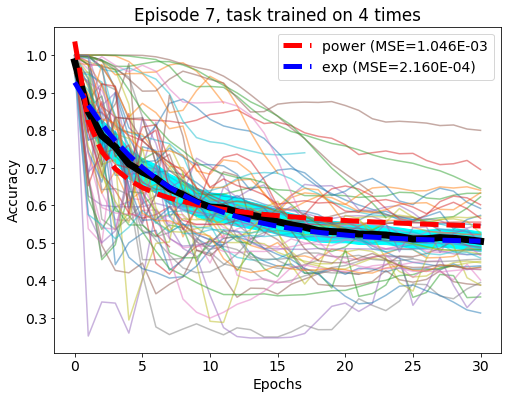

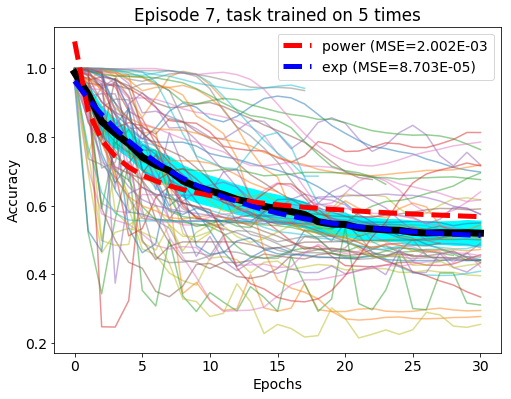

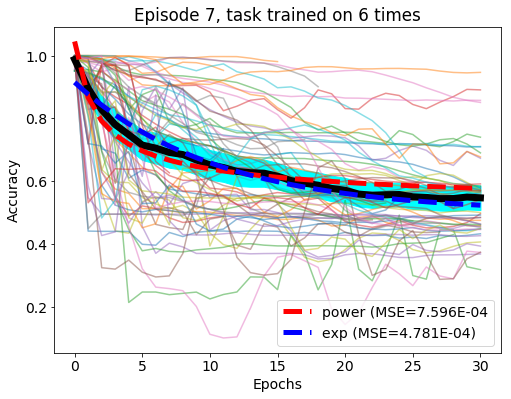

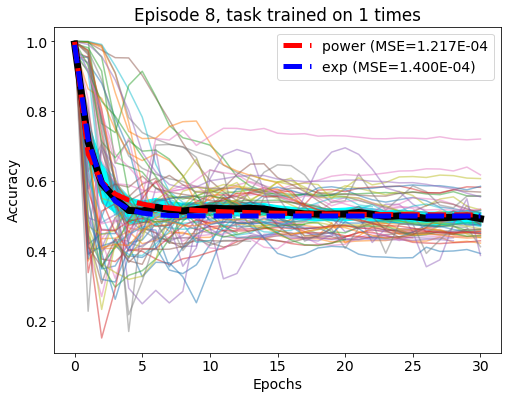

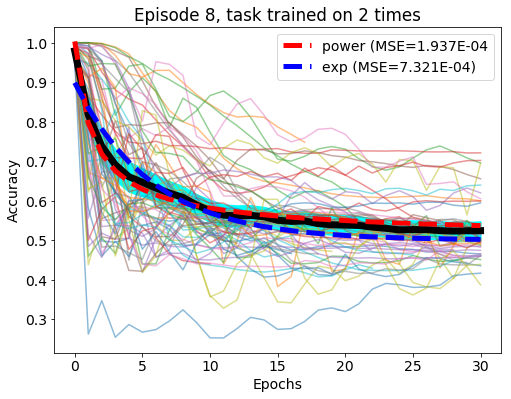

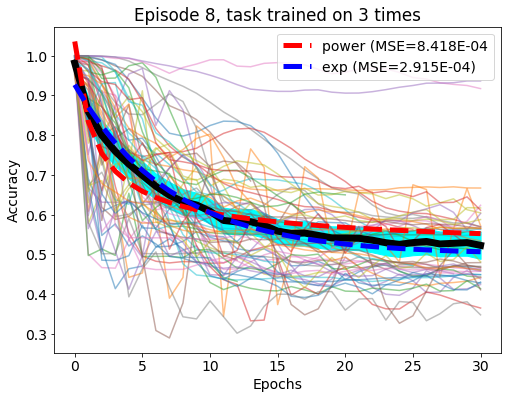

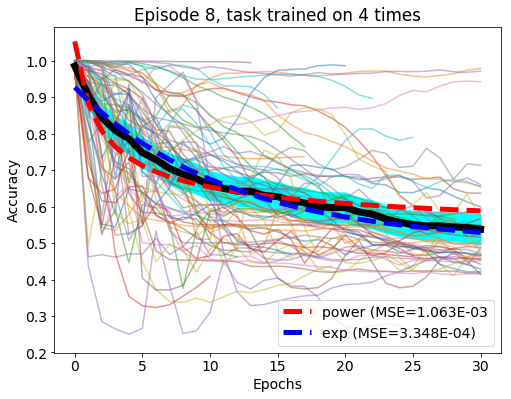

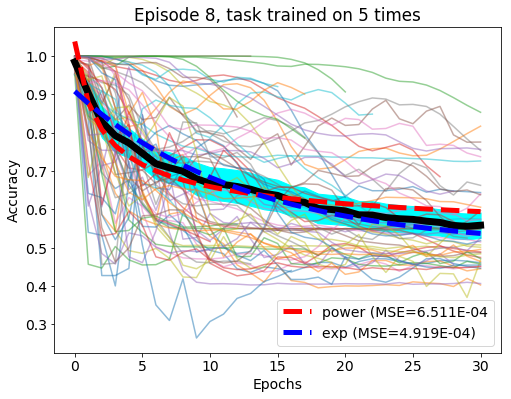

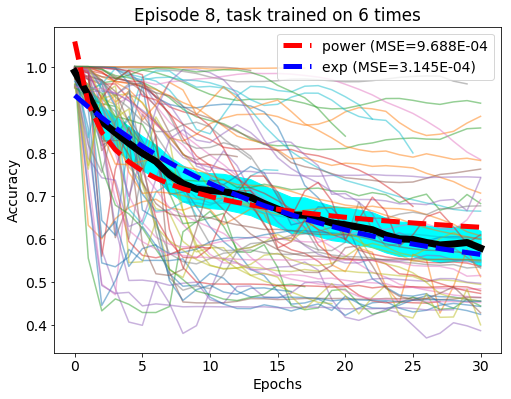

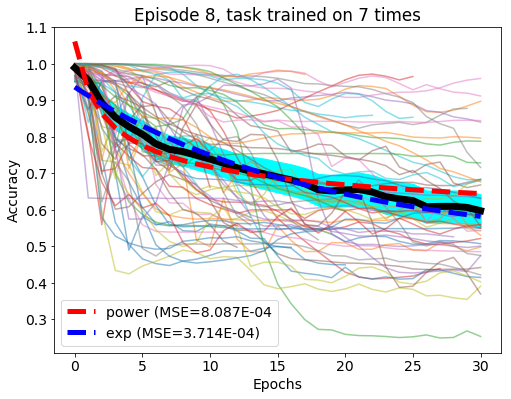

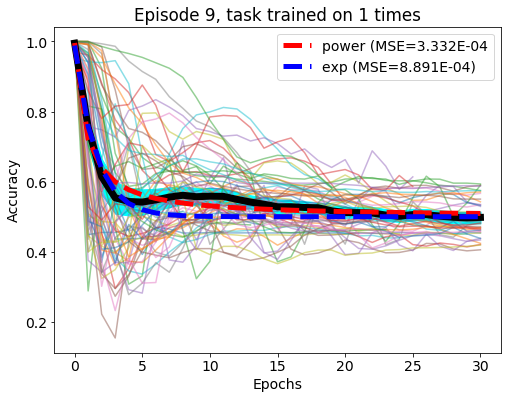

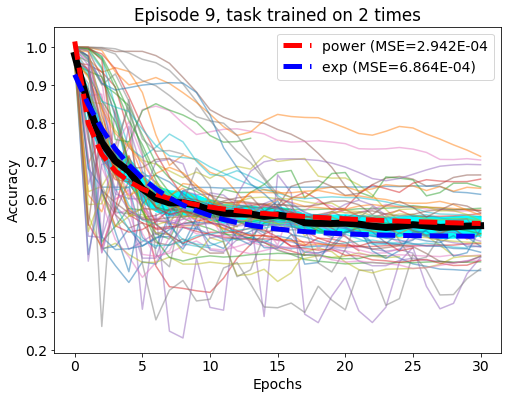

In [ ]:
max_x = 31
num_tasks = 10

total_power_mse = 0
total_exp_mse = 0

for episode_num in range(num_tasks):
    for times_trained in range(num_tasks):
        is_nan = np.isnan(forgetting_curves_raw_data[:, times_trained, episode_num])
        if not np.all(is_nan):
            plt.figure(figsize=(8, 6))
            plt.title(f'Episode {episode_num + 1}, task trained on {times_trained + 1} times')
            
            for sample in range(forgetting_curves_raw_data.shape[0]):
                data = forgetting_curves_raw_data[sample, times_trained, episode_num, :]
                nans = np.isnan(data)
                if not np.any(nans):
                    end = len(data)
                else:
                    end = nans.argmax()
                    
                end = min(max_x, end)
                plt.plot(np.arange(end), data[:end], alpha=0.5)
                
            all_point_data = forgetting_curves_raw_data[:, times_trained, episode_num, :]
            means = np.nanmean(all_point_data, axis=0)
            stds = np.nanstd(all_point_data, axis=0)
            non_nan_counts = np.count_nonzero(~np.isnan(all_point_data), axis=0)
            sems = np.divide(stds, non_nan_counts ** 0.5)
            
            plt.plot(means, linewidth=7, color='black')
            plt.fill_between(np.arange(means.shape[0]), means - 2 * sems, means + 2 * sems,
                             color='cyan')
            
            (alpha_power, beta_power), _ = fit_model(all_point_data, power_decay)
            power_preds = BASELINE + power_decay(np.arange(means.shape[0]), alpha_power, beta_power)
            power_mse = ((power_preds - means) ** 2).mean()
            total_power_mse += power_mse
            
            (alpha_exp, beta_exp), _ = fit_model(all_point_data, exponential_decay)
            exp_preds = BASELINE + exponential_decay(np.arange(means.shape[0]), alpha_exp, beta_exp)
            exp_mse = ((exp_preds - means) ** 2).mean()
            total_exp_mse += exp_mse
            
            plt.plot(power_preds, linewidth=5, linestyle='--', color='red', label=f'power (MSE={power_mse:.3E}')
            plt.plot(exp_preds, linewidth=5, linestyle='--', color='blue', label=f'exp (MSE={exp_mse:.3E})')
            
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend(loc='best')
            plt.show()
            
            
print(f'Total power decay MSE: {total_power_mse}')
print(f'Total exponential decay MSE: {total_exp_mse}')

# Evaluating two different forms of decay curves

In both models, we treat time steps $t \in \{0, 30\}$

## Power function decay:
Fit $\alpha, \beta$, choose a small $\epsilon$ to yield a valid value for $t = 0$:
\begin{align*}
mem =& \alpha (\epsilon + t)^{-\beta} \\
acc =& 0.5 mem + 0.5 \\
acc - 0.5 =& 0.5 \alpha (\epsilon + t)^{-\beta}
\end{align*}

## Exponential decay:
Fit $\alpha, \beta$:
\begin{align*}
mem =& \alpha \exp (-\beta t) \\
acc =& 0.5 mem + 0.5 \\
acc - 0.5 =& 0.5 \alpha \exp (-\beta t) \\
\end{align*}

In [156]:
EPSILON = 1
BASELINE = 0.5
REMAINDER = 1 - BASELINE

def power_decay(x, alpha, beta):
    return REMAINDER * alpha * np.power(x + EPSILON, -beta)

def exponential_decay(x, alpha, beta):
    return REMAINDER * alpha * np.exp(-beta * x)

def extract_x_y(data, baseline=BASELINE):
    x = []
    y = []
    for index in np.ndindex(data.shape):
        val = data[index]
        if not np.isnan(val):
            x.append(index[1])
            y.append(val)

    x = np.array(x)
    y = np.array(y)
    return x, y - baseline

def fit_model(data, model, baseline=BASELINE):
    """
    data is n_replications * n_timesteps, can contain nans
    baseline is what the guessing rate is - 0.5 for binary classification
    """
    x, y = extract_x_y(data, baseline)
    return optimize.curve_fit(model, x, y)

    

In [159]:
fit_model(forgetting_curves_raw_data[:, 6, 7, :], exponential_decay)

(array([0.87174097, 0.05595126]), array([[3.42804171e-04, 3.01371326e-05],
        [3.01371326e-05, 4.96324920e-06]]))

In [149]:
alpha, beta = _[0]

In [167]:
exp_preds = BASELINE + exponential_decay(np.arange(31), alpha, beta)
exp_preds

array([1.06086314, 0.87737668, 0.75391783, 0.67084857, 0.61495543, 0.57734775, 0.55204342,
       0.53501741, 0.52356146, 0.51585332, 0.5106669 , 0.50717723, 0.50482919, 0.50324932,
       0.50218631, 0.50147106, 0.5009898 , 0.50066599, 0.50044811, 0.50030151, 0.50020287,
       0.5001365 , 0.50009185, 0.5000618 , 0.50004158, 0.50002798, 0.50001882, 0.50001267,
       0.50000852, 0.50000573, 0.50000386])

In [171]:
((exp_preds - means) ** 2).mean()

0.04960228085457872

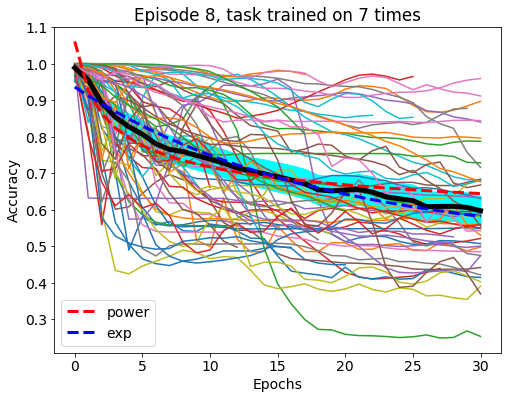

In [163]:
times_trained = 6
episode_num = 7

(alpha_power, beta_power), _ = fit_model(forgetting_curves_raw_data[:, times_trained, episode_num, :], power_decay)
(alpha_exp, beta_exp), _ = fit_model(forgetting_curves_raw_data[:, times_trained, episode_num, :], exponential_decay)

plt.figure(figsize=(8, 6))
plt.title(f'Episode {episode_num + 1}, task trained on {times_trained + 1} times')

for sample in range(forgetting_curves_raw_data.shape[0]):
    data = forgetting_curves_raw_data[sample, times_trained, episode_num, :]
    nans = np.isnan(data)
    if not np.any(nans):
        end = len(data)
    else:
        end = nans.argmax()

    end = min(max_x, end)
    plt.plot(np.arange(end), data[:end])

means = np.nanmean(forgetting_curves_raw_data[:, times_trained, episode_num, :], axis=0)
stds = np.nanstd(forgetting_curves_raw_data[:, times_trained, episode_num, :], axis=0)
non_nan_counts = np.count_nonzero(~np.isnan(forgetting_curves_raw_data[:, 0, 1, :]), axis=0)
sems = np.divide(stds, non_nan_counts ** 0.5)

plt.plot(means, linewidth=5, color='black')
plt.fill_between(np.arange(means.shape[0]), means - 2 * sems, means + 2 * sems,
                 color='cyan')

plt.plot(np.arange(31), BASELINE + power_decay(np.arange(31), alpha_power, beta_power), 
         linewidth=3, linestyle='--', color='red', label='power')
plt.plot(np.arange(31), BASELINE + exponential_decay(np.arange(31), alpha_exp, beta_exp), 
         linewidth=3, linestyle='--', color='blue', label='exp')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Scratch work

In [98]:
mean = np.nanmean(forgetting_curves_raw_data[:, 0, 1, :], axis=0)
mean, mean.shape

(array([0.96787761, 0.72683284, 0.60788657, 0.57031642, 0.56300597, 0.56039403, 0.56310746,
        0.5586597 , 0.55316418, 0.54085672, 0.5352597 , 0.53215821, 0.52736418, 0.52411045,
        0.52217612, 0.51872537, 0.51426364, 0.50942121, 0.509     , 0.50850476, 0.5081873 ,
        0.51062222, 0.51137377, 0.51036667, 0.51407368, 0.51397895, 0.51528929, 0.51536429,
        0.514125  , 0.51636071, 0.51342909]), (31,))

In [94]:
std = np.nanstd(forgetting_curves_raw_data[:, 0, 1, :], axis=0)
std, std.shape

(array([0.01565654, 0.17120495, 0.1468176 , 0.12319639, 0.11138096, 0.09068093, 0.08601856,
        0.08242288, 0.07312301, 0.06756602, 0.07811526, 0.0819031 , 0.08832103, 0.09459885,
        0.0951665 , 0.09425277, 0.09710276, 0.10084273, 0.10272651, 0.10092154, 0.09915076,
        0.09782176, 0.09962751, 0.09864311, 0.09515434, 0.09194264, 0.09169181, 0.08984627,
        0.08965025, 0.08595529, 0.08862352]), (31,))

In [106]:
c = np.count_nonzero(~np.isnan(forgetting_curves_raw_data[:, 0, 1, :]), axis=0)
c ** 0.5

array([8.18535277, 8.18535277, 8.18535277, 8.18535277, 8.18535277, 8.18535277, 8.18535277,
       8.18535277, 8.18535277, 8.18535277, 8.18535277, 8.18535277, 8.18535277, 8.18535277,
       8.18535277, 8.18535277, 8.1240384 , 8.1240384 , 8.        , 7.93725393, 7.93725393,
       7.93725393, 7.81024968, 7.74596669, 7.54983444, 7.54983444, 7.48331477, 7.48331477,
       7.48331477, 7.48331477, 7.41619849])

In [7]:
test_id = 'r6gc4st4'
r = api.run(forgetting_exp_pattern.format(run_id=test_id))

In [8]:
hist = r.history(samples=2000)

In [9]:
tasks_started = [f'Test Accuracy, Query #{current_task}' in hist for current_task in range(2, 11)]
tasks_started

[True, True, True, True, True, True, True, True, True]

In [ ]:
last_task = 2 + len(first_valid) - 1 - first_valid[::-1].index(True)
print(last_task)
hist[f'Test Accuracy, Query #{last_task}'].first_valid_index()

In [ ]:
hist[hist[f'Test Accuracy, Query #{last_task}'].first_valid_index() - 1:]

In [11]:
'step_resumed_from' in r.config

True

In [20]:
np.array(hist[1001:1021]['_timestamp']) - np.array(hist[1000:1020]['_timestamp'])

array([1.66085198e+01, 1.66694536e+01, 1.63797772e+01, 1.62969868e+01, 9.44944525e+04,
       1.79757733e+01, 1.88511190e+01, 1.92735114e+01, 1.80764482e+01, 2.00187039e+01,
       1.81819327e+01, 1.96725266e+01, 1.81217203e+01, 1.84757307e+01, 1.97152829e+01,
       1.82589185e+01, 1.83613744e+01, 1.99383206e+01, 2.04300420e+01, 1.87415736e+01])

In [25]:
hist[900:1100]['_timestamp'].diff().idxmax()

1005

In [22]:
hist[1000:1020]['_timestamp']

1000    1.558124e+09
1001    1.558124e+09
1002    1.558124e+09
1003    1.558124e+09
1004    1.558124e+09
1005    1.558218e+09
1006    1.558218e+09
1007    1.558218e+09
1008    1.558218e+09
1009    1.558218e+09
1010    1.558218e+09
1011    1.558218e+09
1012    1.558218e+09
1013    1.558218e+09
1014    1.558218e+09
1015    1.558218e+09
1016    1.558218e+09
1017    1.558218e+09
1018    1.558219e+09
1019    1.558219e+09
Name: _timestamp, dtype: float64

In [26]:
current_run = r
current_df = hist

In [29]:
step_resumed_from = current_run.config['step_resumed_from']
post_resume_step = current_df[900:1100]['_timestamp'].diff().idxmax()
print(step_resumed_from, post_resume_step)

993 1005


In [28]:
current_df[step_resumed_from - 2:step_resumed_from + 2]

Test AUC  Test Accuracy  Test Accuracy, Query #1  \
991  0.575978      57.588235                   0.5202   
992  0.571286      56.823529                   0.5154   
993  0.988305      98.411765                   0.9984   
994  0.879685      87.950000                   0.9936   

     Test Accuracy, Query #10 Test Accuracy, Query #2 Test Accuracy, Query #3  \
991                       NaN                  0.5048                  0.4642   
992                       NaN                  0.4898                  0.4562   
993                       NaN                  0.9998                  0.9964   
994                       NaN                  0.9894                  0.9744   

    Test Accuracy, Query #4 Test Accuracy, Query #5 Test Accuracy, Query #6  \
991                   0.462                   0.949                     NaN   
992                  0.4556                  0.9516                     NaN   
993                   0.999                  0.9514                     NaN   
994                  0.9598                   0.906                   0.471   

     Test Accuracy, Query #7  \
991                      NaN   
992                      NaN   
993                      NaN   
994                      NaN   

                           ...                          \
991                        ...                           
992                        ...                           
993                        ...                           
994                        ...                           

                                    gradients/fc1.bias  \
991  {'_type': 'histogram', 'values': [1, 0, 0, 0, ...   
992  {'values': [1, 0, 0, 0, 0, 0, 3, 1, 1, 2, 2, 3...   
993                                                NaN   
994  {'_type': 'histogram', 'values': [1, 0, 0, 0, ...   

                                  gradients/fc1.weight  \
991  {'values': [2, 1, 0, 0, 0, 0, 6, 2, 4, 3, 6, 8...   
992  {'_type': 'histogram', 'values': [1, 0, 0, 0, ...   
993                                                NaN   
994  {'_type': 'histogram', 'values': [1, 0, 2, 1, ...   

                              gradients/fcout.fc2.bias  \
991  {'_type': 'histogram', 'values': [1, 1, 1, 0, ...   
992  {'_type': 'histogram', 'values': [1, 1, 0, 0, ...   
993                                                NaN   
994  {'_type': 'histogram', 'values': [1, 0, 0, 0, ...   

                            gradients/fcout.fc2.weight  \
991  {'_type': 'histogram', 'values': [1, 0, 0, 1, ...   
992  {'values': [1, 0, 1, 0, 0, 3, 0, 2, 2, 1, 2, 2...   
993                                                NaN   
994  {'bins': [-3.224113702774048, -3.1338207721710...   

                              gradients/fcout.fc3.bias  \
991  {'values': [1, 1, 2, 1, 2, 0, 0, 2, 2, 2, 4, 0...   
992  {'_type': 'histogram', 'values': [1, 1, 1, 0, ...   
993                                                NaN   
994  {'_type': 'histogram', 'values': [1, 0, 0, 0, ...   

                            gradients/fcout.fc3.weight  \
991  {'_type': 'histogram', 'values': [1, 0, 1, 3, ...   
992  {'_type': 'histogram', 'values': [3, 0, 1, 0, ...   
993                                                NaN   
994  {'bins': [-0.3103986978530884, -0.302613466978...   

                              gradients/fcout.fc4.bias  \
991  {'values': [2, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 2...   
992  {'_type': 'histogram', 'values': [2, 0, 0, 0, ...   
993                                                NaN   
994  {'_type': 'histogram', 'values': [2, 1, 3, 2, ...   

                            gradients/fcout.fc4.weight  \
991  {'bins': [-0.0040759374387562275, -0.003907085...   
992  {'values': [2, 0, 0, 1, 0, 2, 1, 1, 2, 1, 0, 0...   
993                                                NaN   
994  {'bins': [-0.036811329424381256, -0.0349721685...   

                              gradients/fcout.fc5.bias  \
991  {'_type': 'histogram', 'values': [1, 0, 0, 0, ...   
992  {'_type': 'histo

In [30]:
current_df[post_resume_step - 2:post_resume_step + 2]

Test AUC  Test Accuracy  Test Accuracy, Query #1  \
1003  0.705913          71.20                   0.8204   
1004  0.672605          68.65                   0.7850   
1005  0.998748          99.25                   0.9986   
1006  0.865947          86.75                   0.9902   

      Test Accuracy, Query #10 Test Accuracy, Query #2  \
1003                       NaN                  0.8794   
1004                       NaN                  0.8184   
1005                       NaN                     NaN   
1006                       NaN                  0.9948   

     Test Accuracy, Query #3 Test Accuracy, Query #4 Test Accuracy, Query #5  \
1003                  0.6802                  0.6028                  0.5076   
1004                  0.6284                  0.5946                  0.4968   
1005                     NaN                     NaN                     NaN   
1006                  0.9852                  0.9808                   0.803   

     Test Accuracy, Query #6  Test Accuracy, Query #7  \
1003                  0.8092                      NaN   
1004                  0.8186                      NaN   
1005                     NaN                      NaN   
1006                   0.484                      NaN   

                            ...                          \
1003                        ...                           
1004                        ...                           
1005                        ...                           
1006                        ...                           

                                     gradients/fc1.bias  \
1003  {'_type': 'histogram', 'values': [1, 0, 0, 0, ...   
1004  {'values': [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0...   
1005                                                NaN   
1006                                                NaN   

                                   gradients/fc1.weight  \
1003  {'_type': 'histogram', 'values': [1, 3, 3, 0, ...   
1004  {'_type': 'histogram', 'values': [1, 0, 3, 5, ...   
1005                                                NaN   
1006                                                NaN   

                               gradients/fcout.fc2.bias  \
1003  {'_type': 'histogram', 'values': [1, 0, 0, 0, ...   
1004  {'_type': 'histogram', 'values': [1, 0, 0, 0, ...   
1005                                                NaN   
1006                                                NaN   

                             gradients/fcout.fc2.weight  \
1003  {'bins': [-0.8654718399047852, -0.841191768646...   
1004  {'_type': 'histogram', 'values': [1, 0, 0, 0, ...   
1005                                                NaN   
1006                                                NaN   

                               gradients/fcout.fc3.bias  \
1003  {'_type': 'histogram', 'values': [1, 0, 0, 0, ...   
1004  {'_type': 'histogram', 'values': [1, 0, 0, 0, ...   
1005                                                NaN   
1006                                                NaN   

                             gradients/fcout.fc3.weight  \
1003  {'bins': [-0.12265662848949432, -0.11868558079...   
1004  {'_type': 'histogram', 'values': [1, 0, 0, 0, ...   
1005                                                NaN   
1006                                                NaN   

                               gradients/fcout.fc4.bias  \
1003  {'_type': 'histogram', 'values': [1, 0, 1, 0, ...   
1004  {'bins': [-0.016989445313811302, -0.0165874250...   
1005                                                NaN   
1006                                                NaN   

                             gradients/fcout.fc4.weight  \
1003  {'_type': 'histogram', 'values': [1, 0, 0, 1, ...   
1004  {'_type': 'histogram', 'values': [3, 2, 1, 0, ...   
1005                                                NaN   
1006                                                NaN   

                               gradients/fcout.fc5.bias  \
1003  {'_type'

In [35]:
resumed_row = current_df[step_resumed_from:step_resumed_from + 1]
resumed_row

Test AUC  Test Accuracy  Test Accuracy, Query #1  \
993  0.988305      98.411765                   0.9984   

     Test Accuracy, Query #10 Test Accuracy, Query #2 Test Accuracy, Query #3  \
993                       NaN                  0.9998                  0.9964   

    Test Accuracy, Query #4 Test Accuracy, Query #5 Test Accuracy, Query #6  \
993                   0.999                  0.9514                     NaN   

     Test Accuracy, Query #7            ...              gradients/fc1.bias  \
993                      NaN            ...                             NaN   

     gradients/fc1.weight  gradients/fcout.fc2.bias  \
993                   NaN                       NaN   

    gradients/fcout.fc2.weight  gradients/fcout.fc3.bias  \
993                        NaN                       NaN   

    gradients/fcout.fc3.weight gradients/fcout.fc4.bias  \
993                        NaN                      NaN   

    gradients/fcout.fc4.weight gradients/fcout.fc5.bias  \
993                        NaN                      NaN   

    gradients/fcout.fc5.weight  
993                        NaN  

[1 rows x 80 columns]

In [51]:
tasks_active = [not resumed_row[f'Test Accuracy, Query #{i}'].isna().bool() for i in range(1, 11)]
print(tasks_active)
task_to_start = len(tasks_active) - 1 - tasks_active[::-1].index(True) + 2
print(task_to_start)

[True, True, True, True, True, False, False, False, False, False]
6


In [53]:
hist_copy = current_df.copy()

In [55]:
hist_copy.drop(range(step_resumed_from + 1, post_resume_step + 1), axis=0, inplace=True)

In [56]:
hist_copy[step_resumed_from:10]

Empty DataFrame
Columns: [Test AUC, Test Accuracy, Test Accuracy, Query #1, Test Accuracy, Query #10, Test Accuracy, Query #2, Test Accuracy, Query #3, Test Accuracy, Query #4, Test Accuracy, Query #5, Test Accuracy, Query #6, Test Accuracy, Query #7, Test Accuracy, Query #8, Test Accuracy, Query #9, Test Loss, Test Mean Previous-Query Accuracy, Test Per-Query Accuracy (dict).0, Test Per-Query Accuracy (dict).1, Test Per-Query Accuracy (dict).2, Test Per-Query Accuracy (dict).3, Test Per-Query Accuracy (dict).4, Test Per-Query Accuracy (dict).5, Test Per-Query Accuracy (dict).6, Test Per-Query Accuracy (dict).7, Test Per-Query Accuracy (dict).8, Test Per-Query Accuracy (dict).9, Test Per-Query Accuracy (list), Total Train Size, Train AUC, Train Accuracy, Train Accuracy, Query #1, Train Accuracy, Query #10, Train Accuracy, Query #2, Train Accuracy, Query #3, Train Accuracy, Query #4, Train Accuracy, Query #5, Train Accuracy, Query #6, Train Accuracy, Query #7, Train Accuracy, Query #8, Train Accuracy, Query #9, Train Loss, Train Mean Previous-Query Accuracy, Train Per-Query Accuracy (dict).0, Train Per-Query Accuracy (dict).1, Train Per-Query Accuracy (dict).2, Train Per-Query Accuracy (dict).3, Train Per-Query Accuracy (dict).4, Train Per-Query Accuracy (dict).5, Train Per-Query Accuracy (dict).6, Train Per-Query Accuracy (dict).7, Train Per-Query Accuracy (dict).8, Train Per-Query Accuracy (dict).9, Train Per-Query Accuracy (list), _runtime, _step, _timestamp, gradients/conv.batchNorm1.bias, gradients/conv.batchNorm1.weight, gradients/conv.batchNorm2.bias, gradients/conv.batchNorm2.weight, gradients/conv.batchNorm3.bias, gradients/conv.batchNorm3.weight, gradients/conv.batchNorm4.bias, gradients/conv.batchNorm4.weight, gradients/conv.conv1.bias, gradients/conv.conv1.weight, gradients/conv.conv2.bias, gradients/conv.conv2.weight, gradients/conv.conv3.bias, gradients/conv.conv3.weight, gradients/conv.conv4.bias, gradients/conv.conv4.weight, gradients/fc1.bias, gradients/fc1.weight, gradients/fcout.fc2.bias, gradients/fcout.fc2.weight, gradients/fcout.fc3.bias, gradients/fcout.fc3.weight, gradients/fcout.fc4.bias, gradients/fcout.fc4.weight, gradients/fcout.fc5.bias, gradients/fcout.fc5.weight]
Index: []

[0 rows x 80 columns]

In [63]:
hist_copy[step_resumed_from:step_resumed_from + 10]

index  Test AUC  Test Accuracy  Test Accuracy, Query #1  \
993     993  0.988305      98.411765                   0.9984   
994    1006  0.865947      86.750000                   0.9902   
995    1007  0.865540      85.900000                   0.9900   
996    1008  0.854344      84.700000                   0.9804   
997    1009  0.839124      83.750000                   0.9632   
998    1010  0.825896      82.500000                   0.9664   
999    1011  0.819718      81.550000                   0.9708   
1000   1012  0.815320      80.700000                   0.9710   
1001   1013  0.816122      80.950000                   0.9672   
1002   1014  0.809542      80.750000                   0.9588   

      Test Accuracy, Query #10 Test Accuracy, Query #2  \
993                        NaN                  0.9998   
994                        NaN                  0.9948   
995                        NaN                  0.9954   
996                        NaN                   0.995   
997                        NaN                  0.9866   
998                        NaN                  0.9712   
999                        NaN                  0.9696   
1000                       NaN                   0.969   
1001                       NaN                   0.969   
1002                       NaN                  0.9648   

     Test Accuracy, Query #3 Test Accuracy, Query #4 Test Accuracy, Query #5  \
993                   0.9964                   0.999                  0.9514   
994                   0.9852                  0.9808                   0.803   
995                    0.984                  0.9082                  0.8126   
996                   0.9646                   0.867                  0.7632   
997                    0.924                  0.8796                  0.7034   
998                    0.894                  0.8694                  0.6618   
999                    0.884                  0.8422                  0.6336   
1000                   0.872                  0.8216                  0.6204   
1001                  0.8588                  0.8166                  0.6214   
1002                  0.8422                  0.8064                  0.6218   

     Test Accuracy, Query #6            ...              gradients/fc1.bias  \
993                      NaN            ...                             NaN   
994                    0.484            ...                             NaN   
995                   0.4924            ...                             NaN   
996                    0.539            ...                             NaN   
997                   0.5982            ...                             NaN   
998                   0.6176            ...                             NaN   
999                   0.6108            ...                             NaN   
1000                  0.6156            ...                             NaN   
1001                  0.6516            ...                             NaN   
1002                  0.6752            ...                             NaN   

      gradients/fc1.weight  gradients/fcout.fc2.bias  \
993                    NaN                       NaN   
994                    NaN                       NaN   
995                    NaN                       NaN   
996                    NaN                       NaN   
997                    NaN                       NaN   
998                    NaN                       NaN   
999                    NaN                       NaN   
1000                   NaN                       NaN   
1001                   NaN                       NaN   
1002                   NaN                       NaN   

      gradients/fcout.fc2.weight gradients/fcout.fc3.bias  \
993                          NaN                      NaN   
994                          NaN                      NaN   
995                          NaN                      NaN   
996                          NaN       

In [62]:
hist_copy.reset_index(inplace=True)

In [69]:
results = analysis.parse_forgetting_results('r6gc4st4')

Starting to parse run r6gc4st4


In [72]:
results = np.expand_dims(results, 0)

(1, 10, 10, 31)

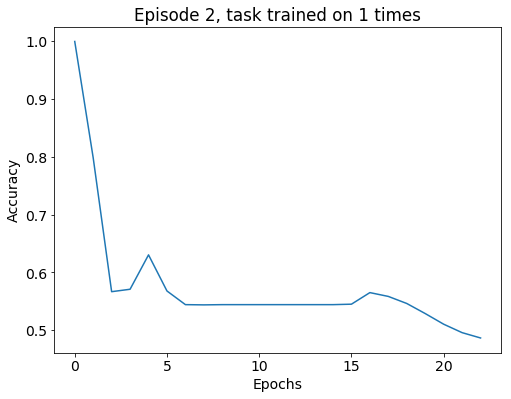

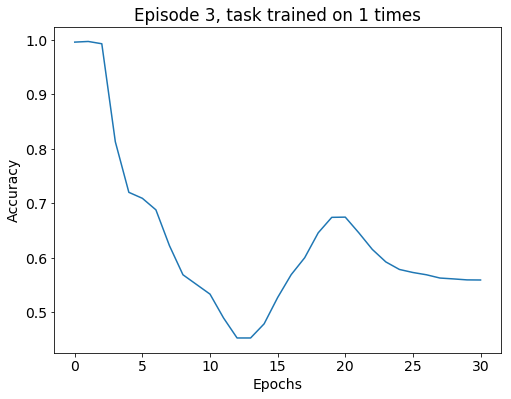

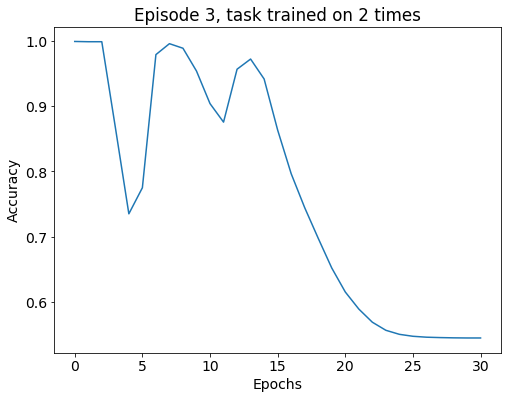

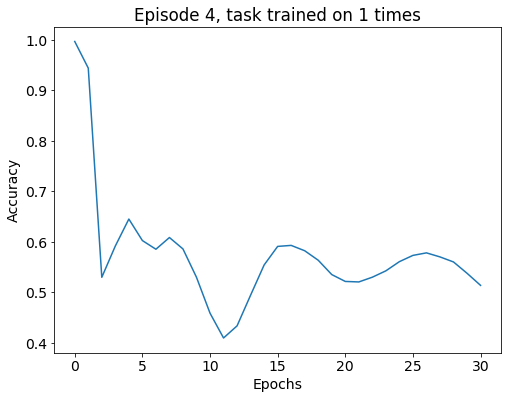

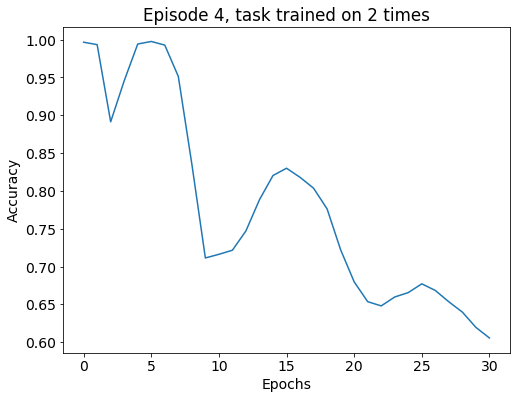

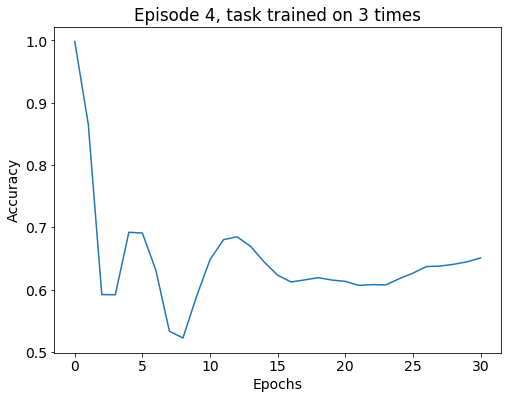

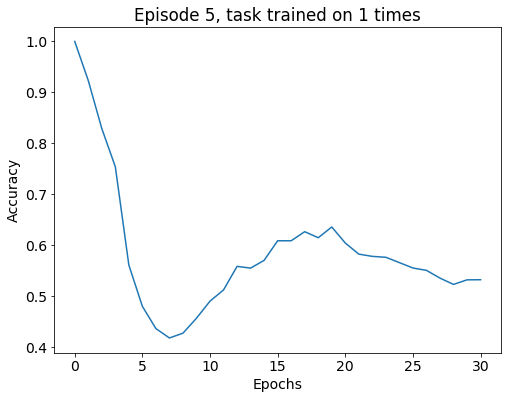

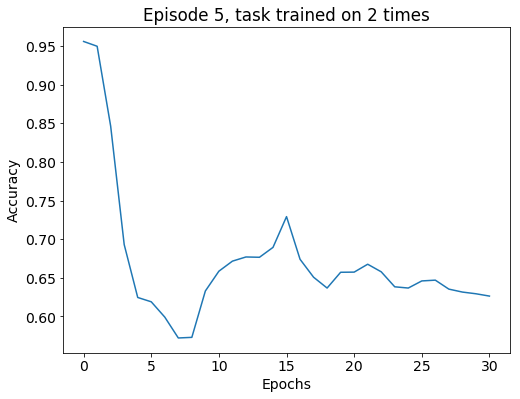

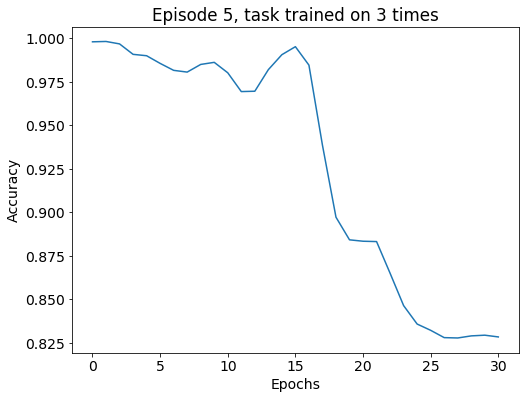

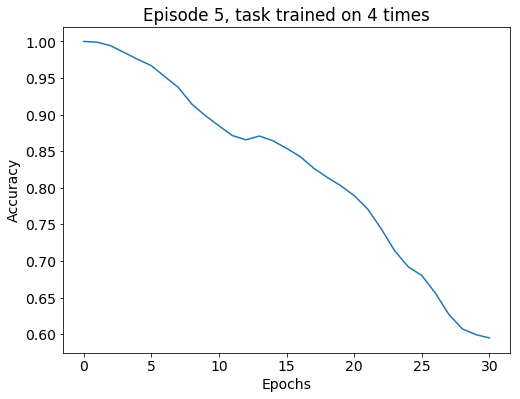

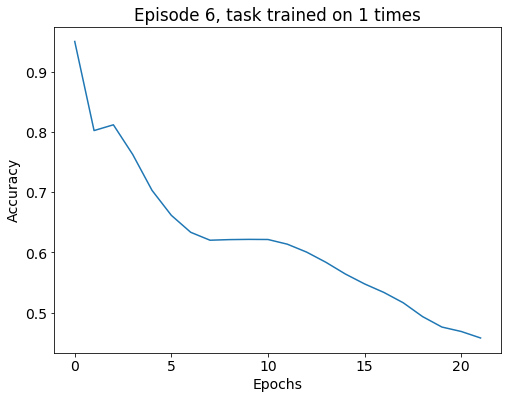

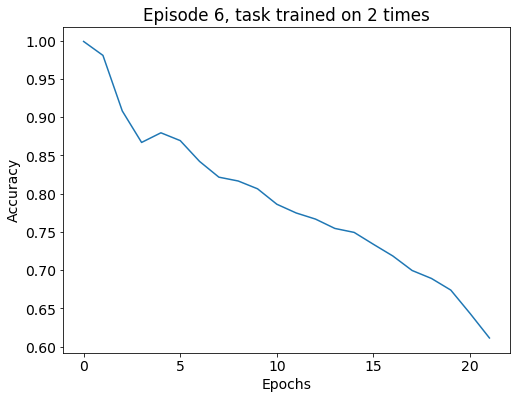

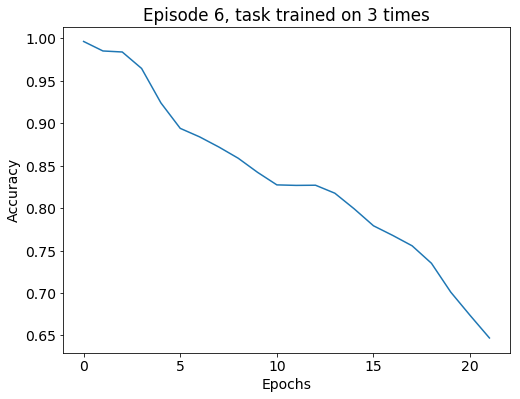

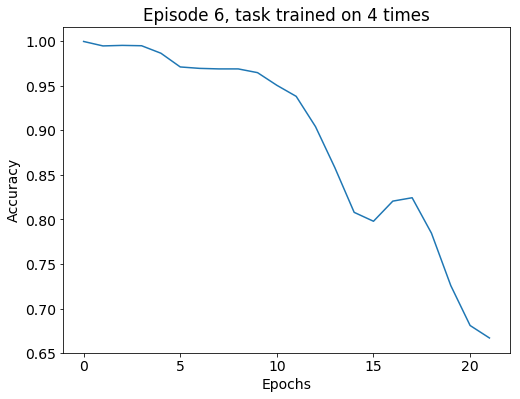

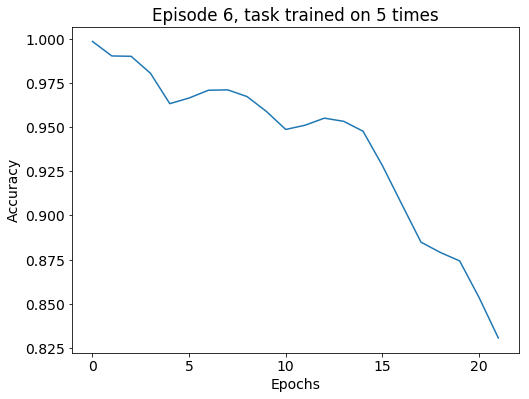

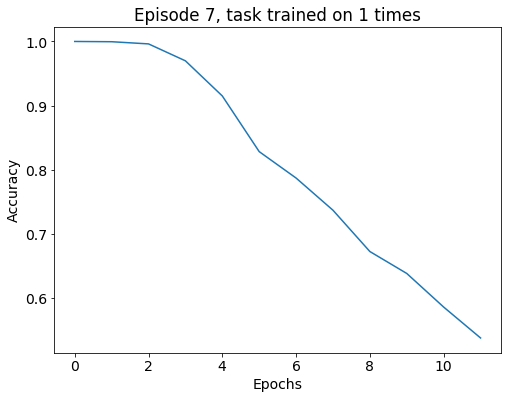

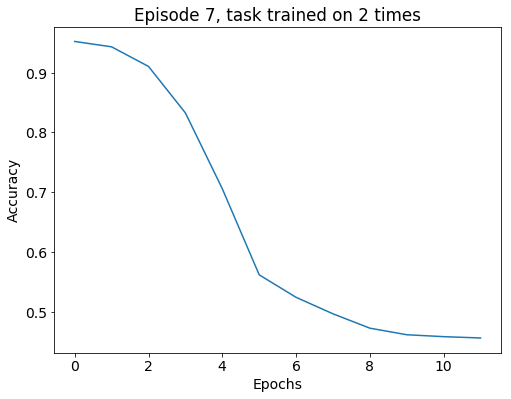

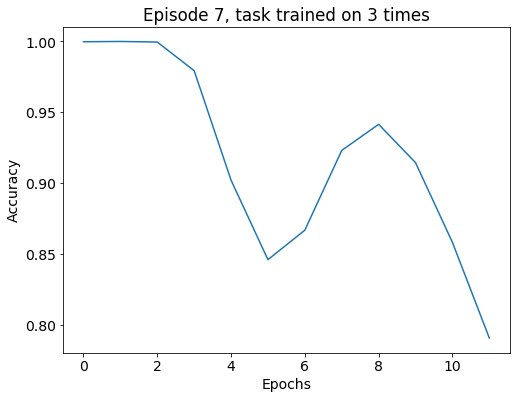

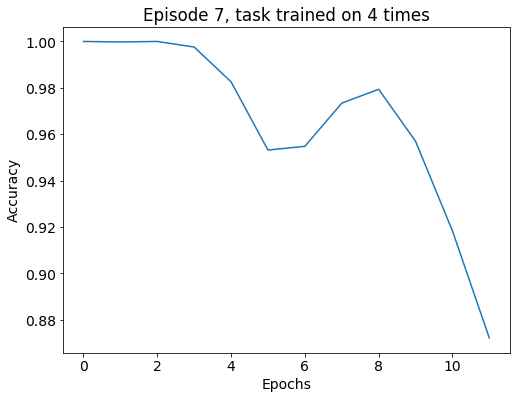

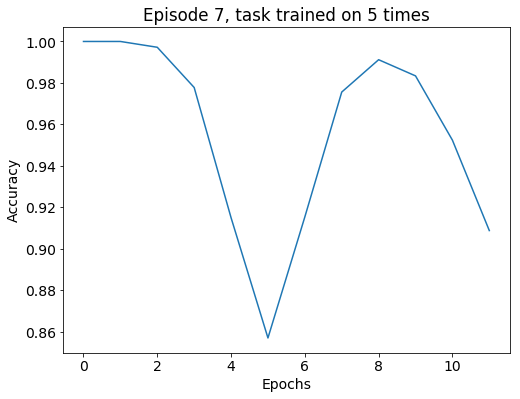

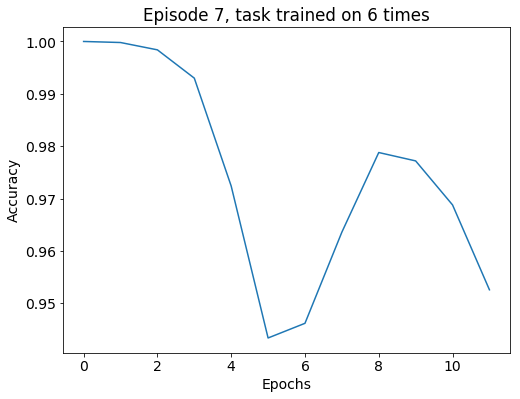

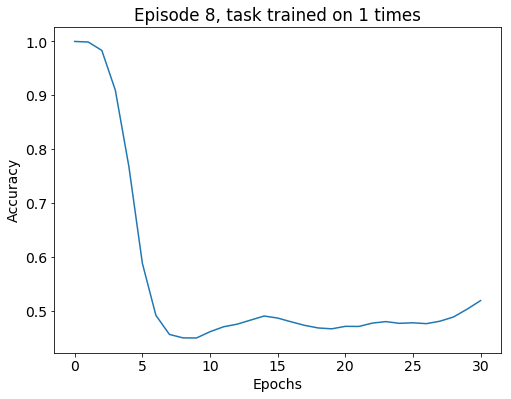

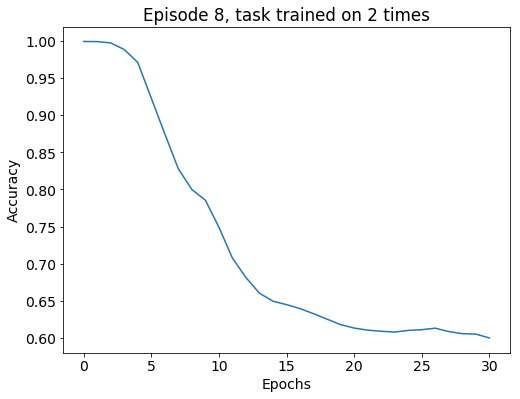

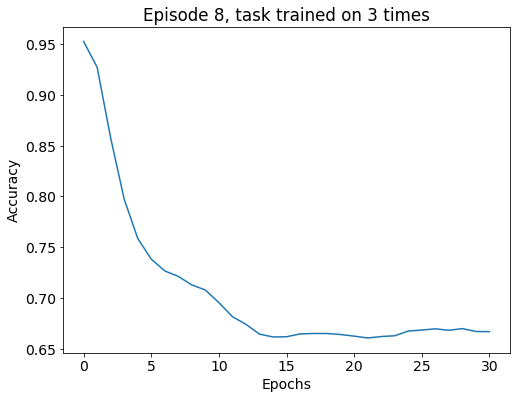

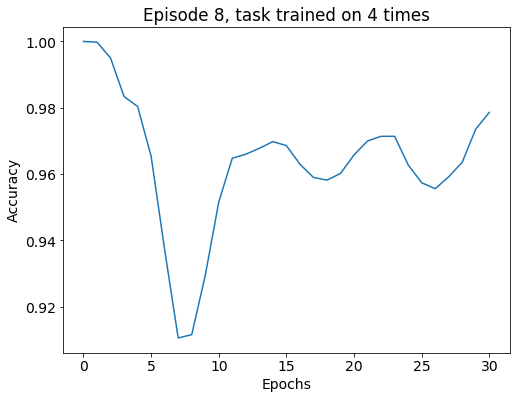

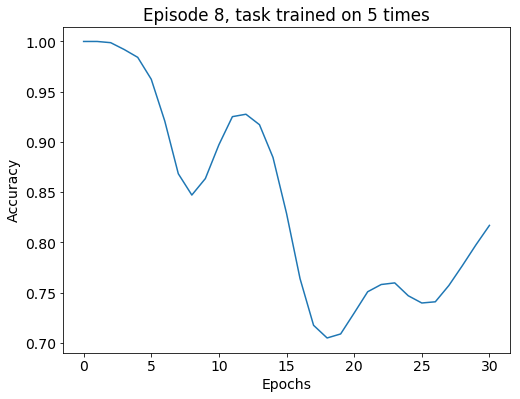

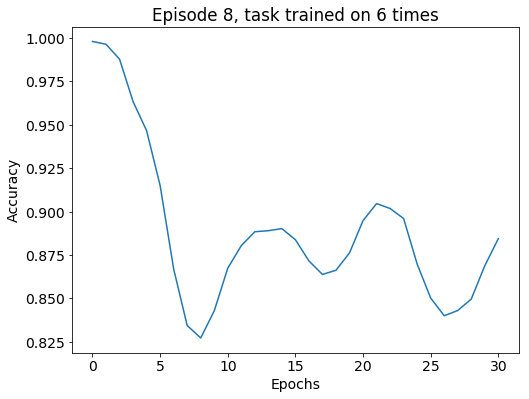

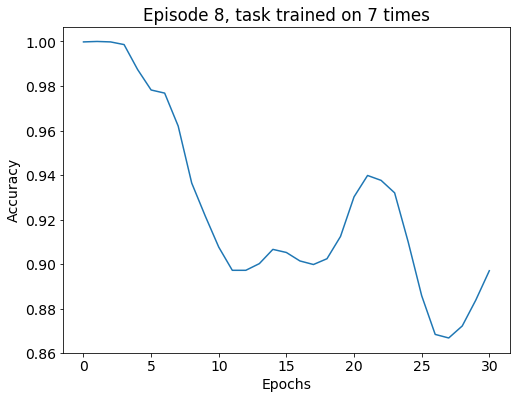

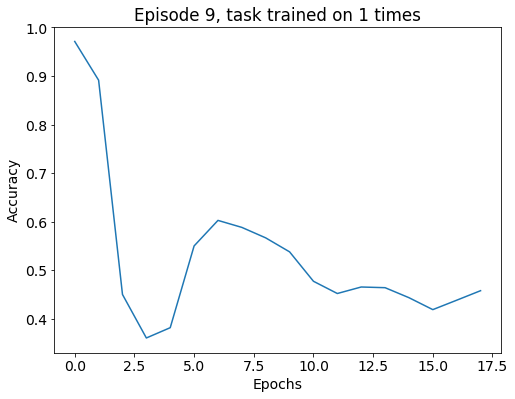

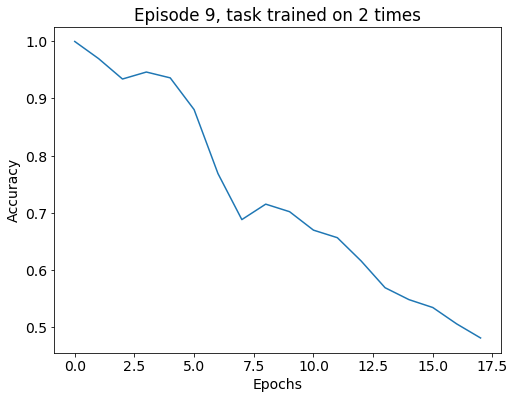

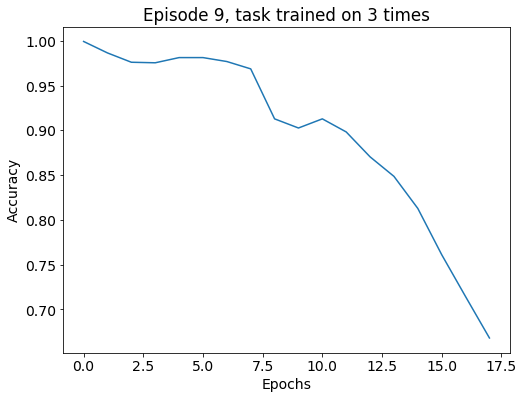

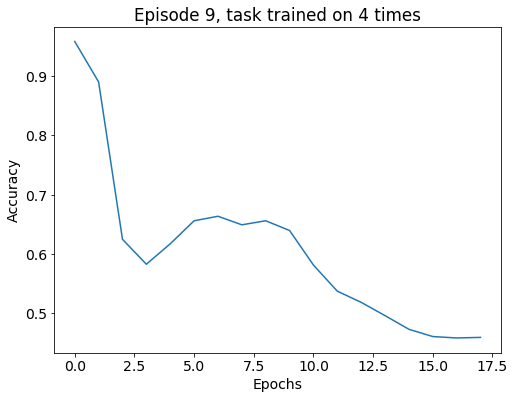

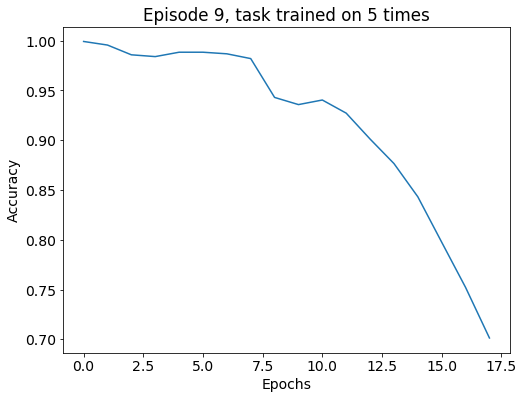

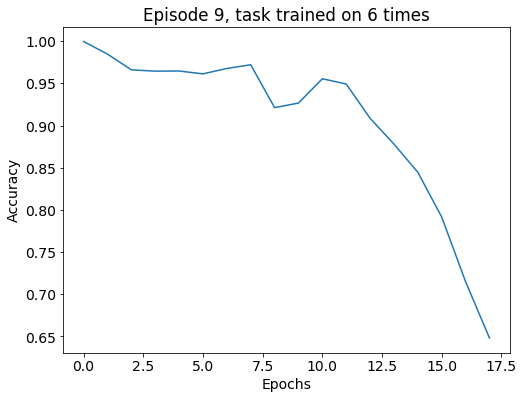

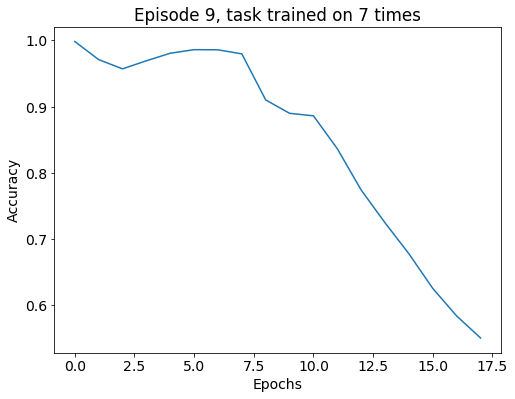

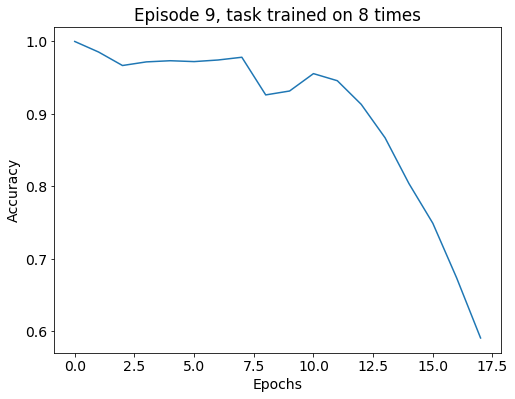

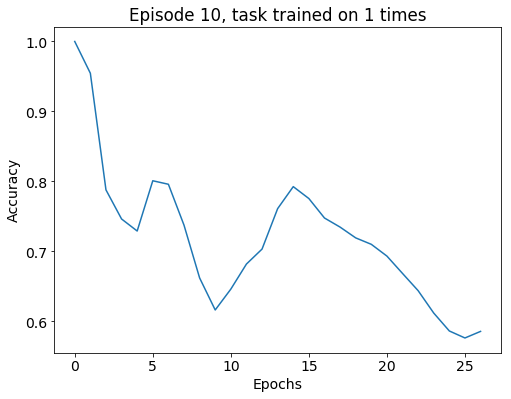

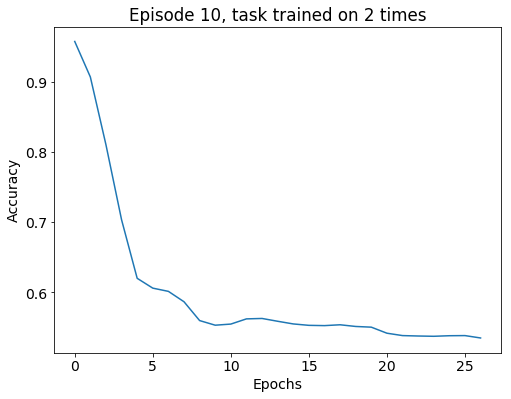

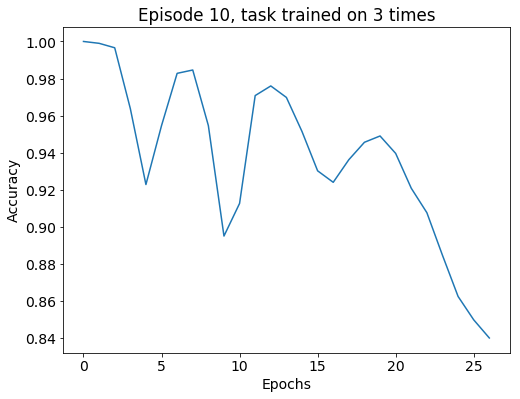

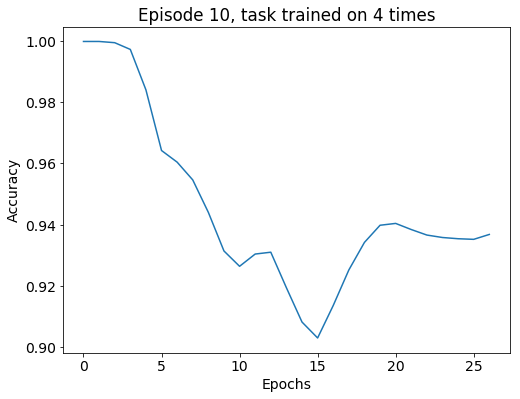

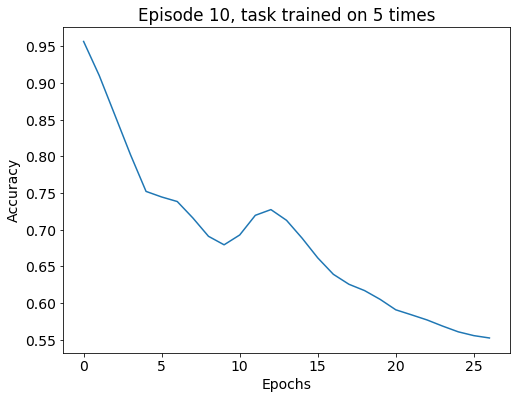

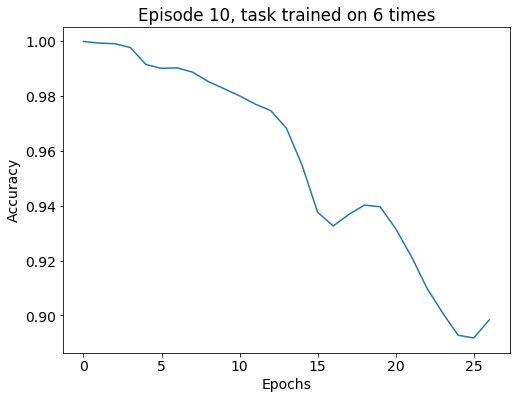

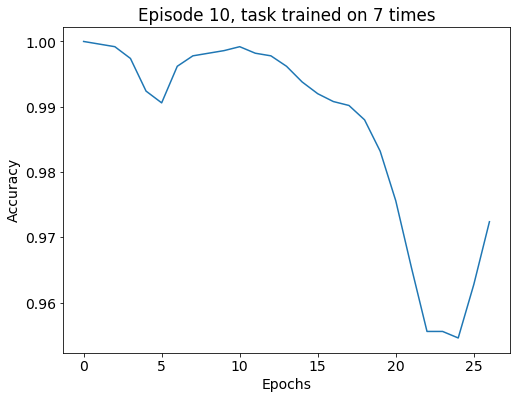

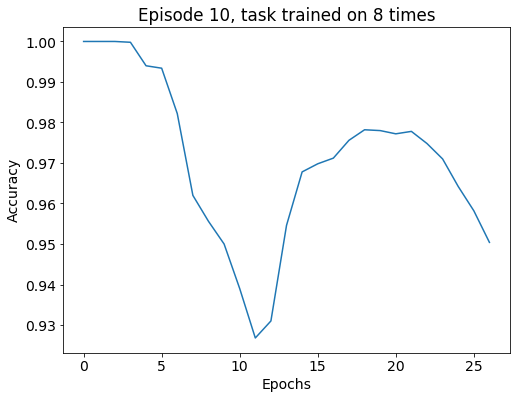

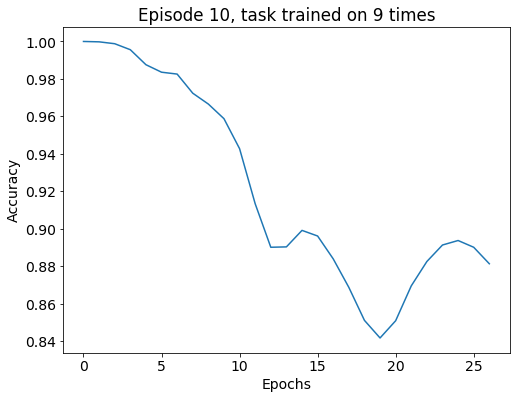

In [75]:
max_x = 31

for episode_num in range(10):
    for times_trained in range(10):
        is_nan = np.isnan(results[0, times_trained, episode_num])
        if not np.all(is_nan):
            plt.figure(figsize=(8, 6))
            plt.title(f'Episode {episode_num + 1}, task trained on {times_trained + 1} times')
            
            data = results[0, times_trained, episode_num, :]
            nans = np.isnan(data)
            if not np.any(nans):
                end = len(data)
            else:
                end = nans.argmax()

            end = min(max_x, end)
            plt.plot(data[:end])
            
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend(loc='best')
            plt.show()

